<a href="https://colab.research.google.com/github/YolandaMDavis/wildtrack-iqa/blob/subjective-classification-performance/Incorrect_classifications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Subjective Performance Analysis

In this notebook we have a closer review of images that did not classify well based on subjective analysis. 

## Retrieve Model and Define Utility Functions

In [1]:
#Only needed to copy data to local drive can be skipped if zip file is already available in working folder
import shutil

# mount google drive
from google.colab import drive
drive.mount('/content/drive') # for google colab. adjust accordingly
PARENT_DIR = '/content/drive/MyDrive/Wildtrack Group/IQA' 

# copy and extract tar file
shutil.copy(PARENT_DIR + '/data/Annotated_Cropped_WildTrack.zip', 'Cropped_WildTrack.zip')

# get downstream task model
shutil.copy(PARENT_DIR + '/task-amenability/species/model.pt', 'species_model.pt')

shutil.copy(PARENT_DIR + '/task-amenability/object/model.pt', 'object_model.pt')


Mounted at /content/drive


'object_model.pt'

In [2]:
# clone the repository and move data file
!git clone https://github.com/YolandaMDavis/wildtrack-iqa.git
!mv Cropped_WildTrack.zip wildtrack-iqa/.
!mv species_model.pt wildtrack-iqa/.
!mv object_model.pt wildtrack-iqa/.
%cd "wildtrack-iqa"
!mv species_model.pt taskamenability/taskpredictor/species/model.pt
!mv object_model.pt taskamenability/taskpredictor/objdet/model.pt


Cloning into 'wildtrack-iqa'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 199 (delta 33), reused 30 (delta 30), pack-reused 149
Receiving objects: 100% (199/199), 24.02 MiB | 38.25 MiB/s, done.
Resolving deltas: 100% (85/85), done.
/content/wildtrack-iqa


In [3]:
from zipfile import ZipFile

# extract image zip file
with ZipFile('Cropped_WildTrack.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [4]:
#%cd "wildtrack-iqa"

import torch
import torchvision
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import cv2
import json
import numpy as np
import albumentations as A

# copy files and load species classification model
with open('taskamenability/taskpredictor/species/class_mapping.json') as data:
    mappings = json.load(data)

class_mapping = {item['model_idx']: item['class_name'] for item in mappings}
device = torch.device('cpu')
model = torch.jit.load('taskamenability/taskpredictor/species/model.pt').to(device)
transforms = A.load('taskamenability/taskpredictor/species/transforms.json')

In [5]:
from torch.utils import data
import csv
import random
import torch
import yaml
import cv2
import os

from time import process_time
from torch.utils.data import Dataset

root_dir = '/content/wildtrack-iqa'
data_dir = root_dir + '/RAW'

def get_key(val, item_dict):
    for key, value in item_dict.items():
        if val == value:
            return key
    return -1

def createImageSamples(img_shape, num_samples):
  x = np.random.rand(num_samples, img_shape[0], img_shape[1], img_shape[2])
  y = np.random.randint(low=0, high=2, size=(num_samples, 1))
  return (x,y)

def generate_data_sets(sample_percentage=1):

    image_reference_list = []
    subdirectories = list(os.walk(data_dir, topdown=False))[:-1]

    for subdir in subdirectories:
        image_location = subdir[0]
        images = subdir[2]
        species_rating = image_location.rsplit('/', 1)[-1].replace('_', ' ')
        subjective_score = int(species_rating.rsplit(' ', 1)[-1])
        species_class = species_rating.rsplit(' ', 1)[:-1][0]
        if len(species_class.rsplit(' ', 1)) > 1:
            species = species_class.rsplit(' ')[0]
            animal_class = ' '.join(species_class.rsplit(' ')[1:])
        else:
            animal_class = 'Unknown'
            species = species_class

        for image in images:
            class_name = species if animal_class == 'Unknown' else species + ': ' + animal_class
            class_index = get_key(class_name, class_mapping)
            if class_index > -1:
              image_reference = (image_location, species, animal_class, image, class_index, subjective_score)
              image_reference_list.append(image_reference)
    

    # shuffle then split
    seed = 1234
    random.Random(seed).shuffle(image_reference_list)

    train_index = int(len(image_reference_list) * 0.6 * sample_percentage)
    test_index = -int(len(image_reference_list) * 0.2 * sample_percentage) 
    val_index = test_index * 2

    training = image_reference_list[:train_index]
    validation = image_reference_list[val_index:test_index]
    testing = image_reference_list[test_index:]
    return training, validation, testing

def convert_image(img_test):
    image = Image.open(img_test)
    #convert bw to RGB
    bands = image.getbands()
    if len(bands) == 1:
      image = image.convert(mode='RGB')
    image = np.array(image)
    image = transforms(image=image)['image']
    x = torch.from_numpy(image).to(device)
    return x


def transform_images(images):
  x = []
  y = []
  for img in images:
      image_name = img[0]+'/'+img[3]
      image = convert_image(image_name)
      x.append(image)
      y.append(img[4])

  return np.array(x), np.array(y)


## Generate Analysis Data Set

In [6]:
# take a percentage of the full data set as a training/test/validation sample
sample_size=.5
train, valid, test = generate_data_sets(sample_size)
x_train, y_train = transform_images(train)
x_val, y_val = transform_images(valid)
x_test, y_test = transform_images(test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## Create Misclassification Data Slices

In [14]:
# Create list of predictions for test set images

class_preds = []
for item in x_test:
  obs = item.permute(2, 0, 1).unsqueeze(dim=0).float()
  y_pred = model(obs)
  y_pred = y_pred.argmax(dim=1).squeeze().item()
  class_preds.append(y_pred)

# getting list of images that were scored incorrectly
class_actuals = [ item[4] for item in test]
subjective_quality = [ item[5] for item in test]


In [15]:
# Generate lists of misclassified images
sub_low_actual_high = [] # images deemed as low quality yet could be classified by model
sub_high_actual_low = []  # images deemed as high quality yet could not be classified by model

for i in range(len(class_actuals)):
  if class_preds[i] == class_actuals[i] and subjective_quality[i] < 4:
    sub_low_actual_high.append(i)
  elif class_preds[i] != class_actuals[i] and subjective_quality[i] >= 4:
    sub_high_actual_low.append(i)
  else:
    pass

## Export Misclassified Images

In [9]:
# images where subjective scored low but actual classification said it was classifiable
dst_dir = PARENT_DIR + '/Incorrect classification/sub_low_actual_high'
for x in sub_low_actual_high:
  species = test[x][1] + '_' + test[x][2]
  folder = os.path.join(dst_dir, species)
  if not os.path.exists(folder):
    os.mkdir(folder)
  fp = test[x][0] + '/' + test[x][3]
  shutil.copy(fp, folder)

In [10]:
 # images where subjective scored high but actual classification said it was not classifiable
dst_dir = PARENT_DIR + '/Incorrect classification/sub_high_actual_low'
for x in sub_high_actual_low:
  species = test[x][1] + '_' + test[x][2]
  folder = os.path.join(dst_dir, species)
  if not os.path.exists(folder):
    os.mkdir(folder)
  fp = test[x][0] + '/' + test[x][3]
  shutil.copy(fp, folder)


## Display Misclassified Images

In [11]:
from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO

import pandas as pd
import glob
import random
import base64
import io

def get_thumbnail(path):
    i = Image.open(path)  
    i = i.resize((512,512))  
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'


test_df = pd.DataFrame(test, columns =['image_dir', 'species', 'sub_species','image_name','classification','subj_quality_score'])

for i, row in test_df.iterrows():
    img_path = row['image_dir'] +'/' + row['image_name'] 
    test_df.at[i,'image_html'] =  image_formatter(img_path)
    test_df.at[i,'misclassified_high'] = 1 if i in sub_high_actual_low else 0
    test_df.at[i,'misclassified_low'] = 1 if i in sub_low_actual_high else 0
  

test_df.sort_values(by=['species'],inplace=True)

### Images Misclassified as High Quality

,image_dir,species,sub_species,image_name,classification,subj_quality_score,image_html,misclassified_high,misclassified_low
314,/content/wildtrack-iqa/RAW/Bongo_Eastern_Mountain_4,Bongo,Eastern Mountain,60e5e540d3dd11ea91590242ac1c0002_.jpg,13,4,,1.0,0.0
332,/content/wildtrack-iqa/RAW/Cheetah_Southeast_African_5,Cheetah,Southeast African,98616d50d3dd11ea91590242ac1c0002_.jpg,11,5,,1.0,0.0
47,/content/wildtrack-iqa/RAW/Elephant_African_4,Elephant,African,13270c80d3dd11ea91590242ac1c0002_.jpg,3,4,,1.0,0.0
48,/content/wildtrack-iqa/RAW/Elephant_African_5,Elephant,African,16849686c0fa11ea82a50242ac1c0002_.jpg,3,5,,1.0,0.0
289,/content/wildtrack-iqa/RAW/Elephant_African_5,Elephant,African,14731098c0fa11ea82a50242ac1c0002_.jpg,3,5,,1.0,0.0
197,/content/wildtrack-iqa/RAW/Jaguar_4,Jaguar,Unknown,af7110c2c0fa11ea82a50242ac1c0002_.jpg,4,4,,1.0,0.0
122,/content/wildtrack-iqa/RAW/Jaguar_4,Jaguar,Unknown,bc4a713cc0fd11ea82a50242ac1c0002_.jpg,4,4,,1.0,0.0
34,/content/wildtrack-iqa/RAW/Leopard_African_4,Leopard,African,1dfb70ca0db111eb9d950242ac110002_.jpg,7,4,,1.0,0.0
40,/content/wildtrack-iqa/RAW/Leopard_African_5,Leopard,African,ddd5c624d63011eab2300242ac1c0002_.jpg,7,5,,1.0,0.0
244,/content/wildtrack-iqa/RAW/Lion_African_4,Lion,African,8c50a224d3dd11ea91590242ac1c0002_.jpg,12,4,,1.0,0.0

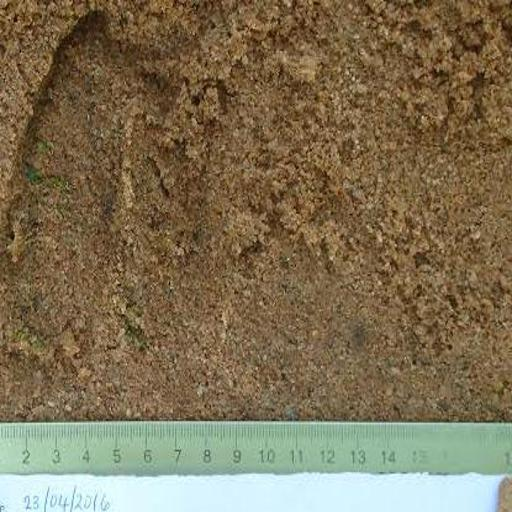
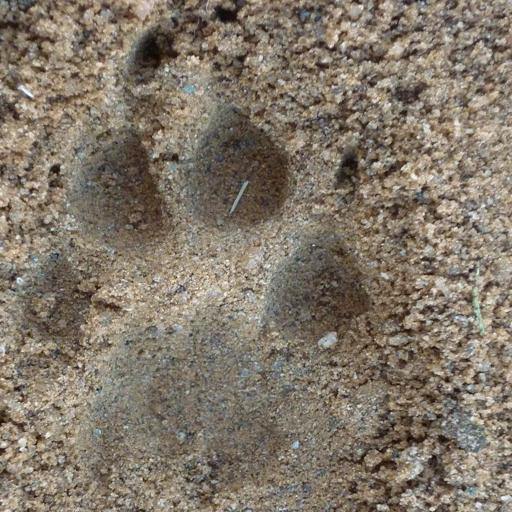
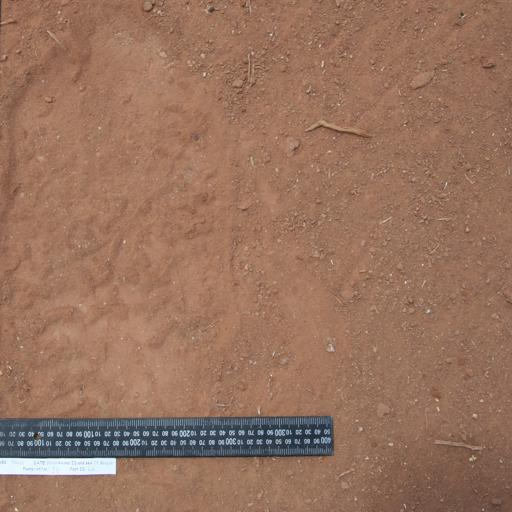
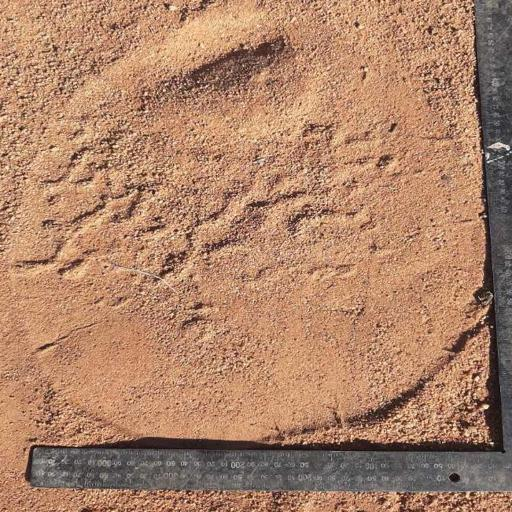
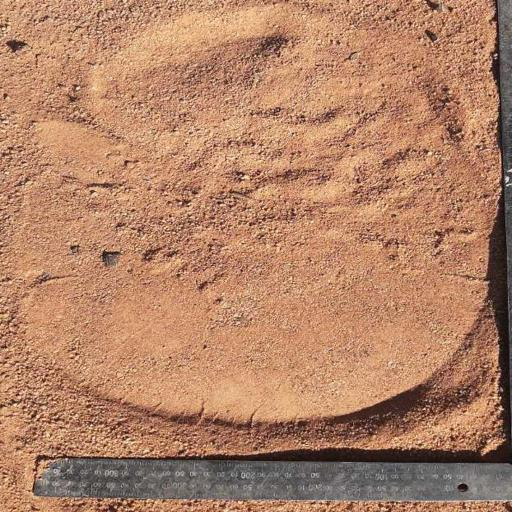
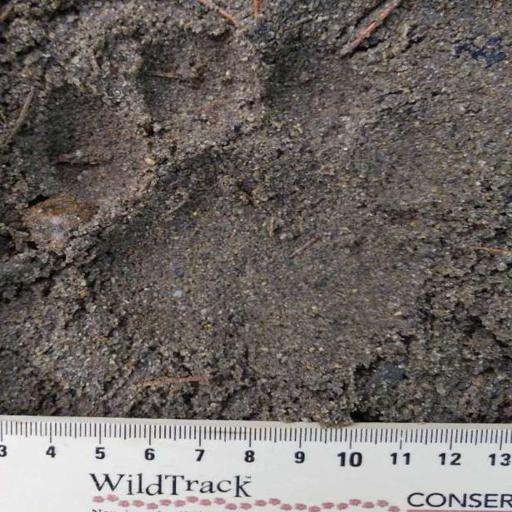
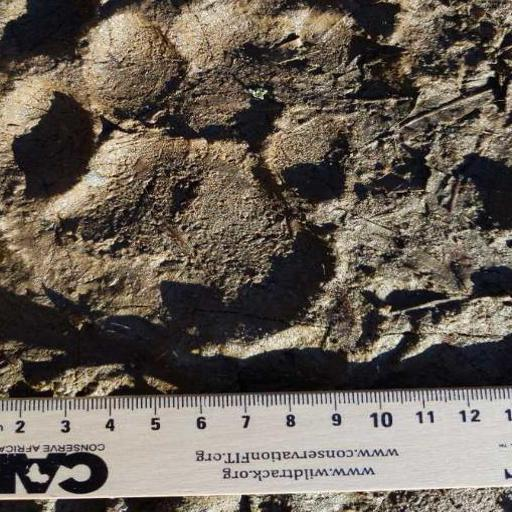
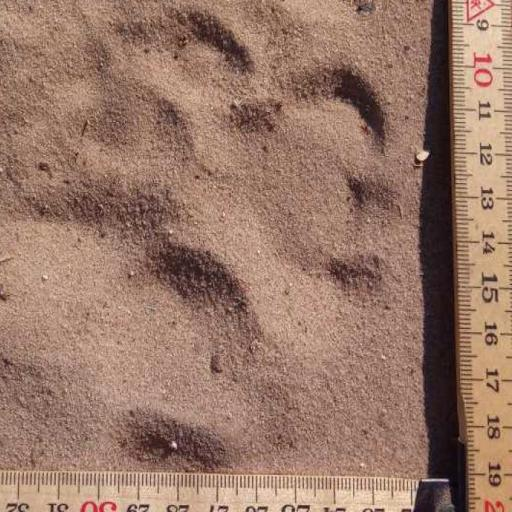
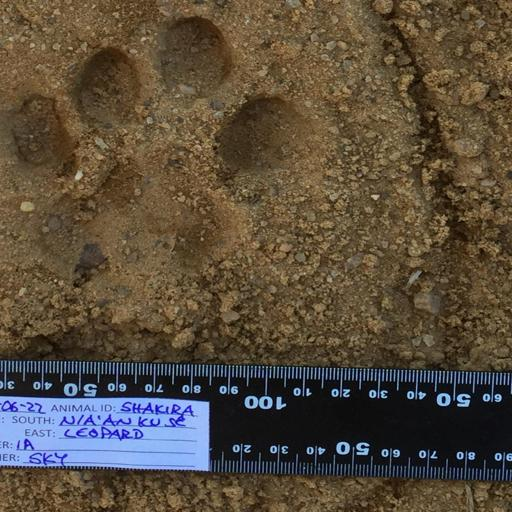
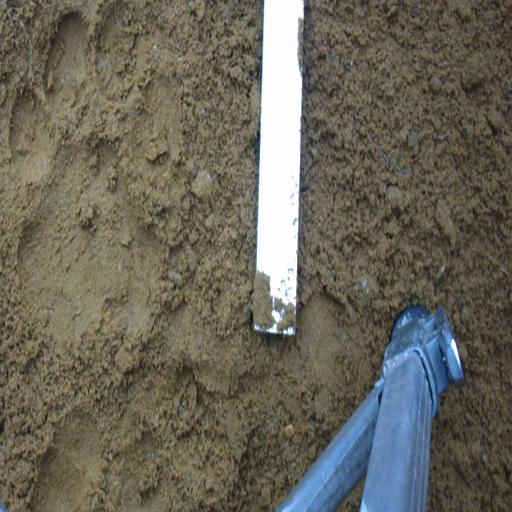

In [17]:
#sample first 10 images for review
misclassified_high_df = test_df[test_df['misclassified_high'] == 1].head(10)

high_html = misclassified_high_df.to_html(escape=False)
display(HTML(high_html))

#### Visual Analysis

In the example of African lions (same goes from African Leopards), it seems images with high brightness/exposure tends to be harder to classify. On the contrary images where darker tones are more classifiable.


### Images Misclassified as Low Quality

,image_dir,species,sub_species,image_name,classification,subj_quality_score,image_html,misclassified_high,misclassified_low
78,/content/wildtrack-iqa/RAW/Cheetah_Southeast_African_3,Cheetah,Southeast African,64d2225ea12811eb9ffb00155d381c3b_.jpg,11,3,,0.0,1.0
279,/content/wildtrack-iqa/RAW/Cheetah_Southeast_African_3,Cheetah,Southeast African,0297e6209d5c11eba87900155d8f37d3_.jpg,11,3,,0.0,1.0
63,/content/wildtrack-iqa/RAW/Elephant_African_3,Elephant,African,0f2ec424d3dd11ea91590242ac1c0002_.jpg,3,3,,0.0,1.0
343,/content/wildtrack-iqa/RAW/Jaguar_3,Jaguar,Unknown,31751c46fa0b11ea9d950242ac110002_.jpg,4,3,,0.0,1.0
236,/content/wildtrack-iqa/RAW/Jaguar_3,Jaguar,Unknown,bdb93364c0a711eba0d400155ddbfef5_.jpg,4,3,,0.0,1.0
120,/content/wildtrack-iqa/RAW/Jaguar_3,Jaguar,Unknown,c42eac36d3dd11ea91590242ac1c0002_.jpg,4,3,,0.0,1.0
305,/content/wildtrack-iqa/RAW/Jaguar_3,Jaguar,Unknown,c537950cd3dd11ea91590242ac1c0002_.jpg,4,3,,0.0,1.0
247,/content/wildtrack-iqa/RAW/Jaguar_3,Jaguar,Unknown,183ea668f55411ea9d950242ac110002_.jpg,4,3,,0.0,1.0
260,/content/wildtrack-iqa/RAW/Jaguar_3,Jaguar,Unknown,84fe6916c0b811eb813200155da81a1d_.jpg,4,3,,0.0,1.0
183,/content/wildtrack-iqa/RAW/Jaguar_3,Jaguar,Unknown,5e1d8c92ba5e11ebbd6700155d20dec6_.jpg,4,3,,0.0,1.0

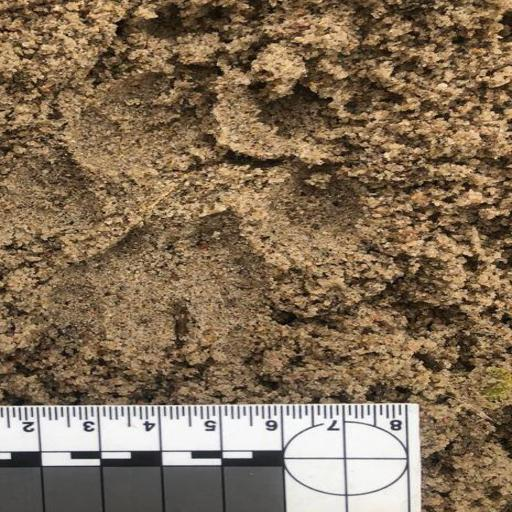
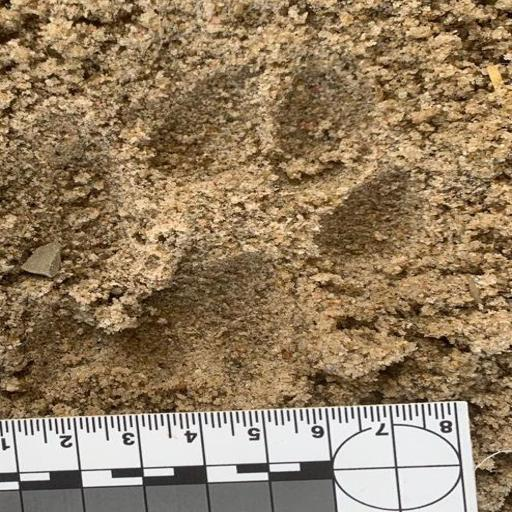
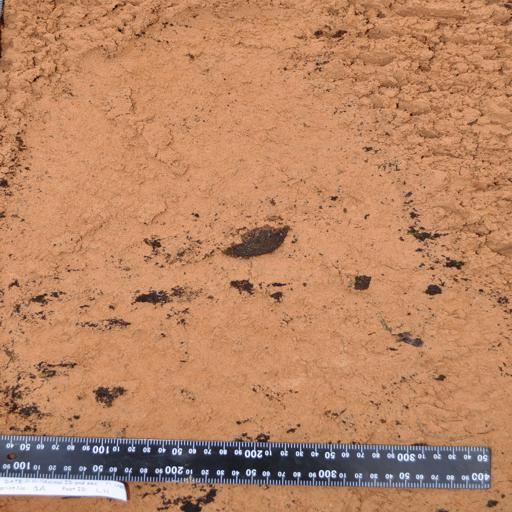
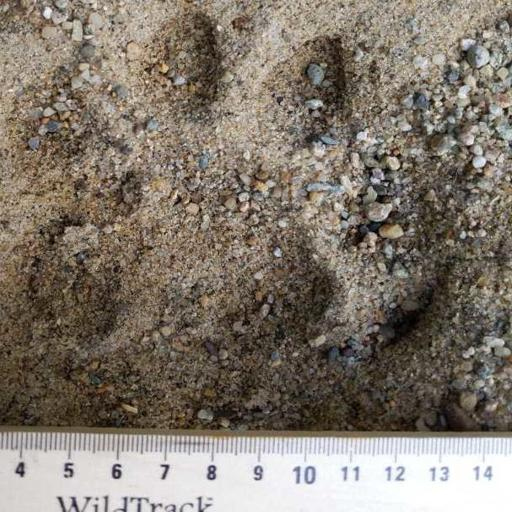
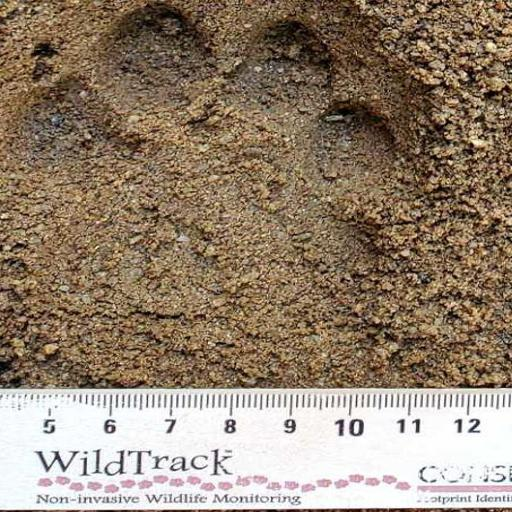
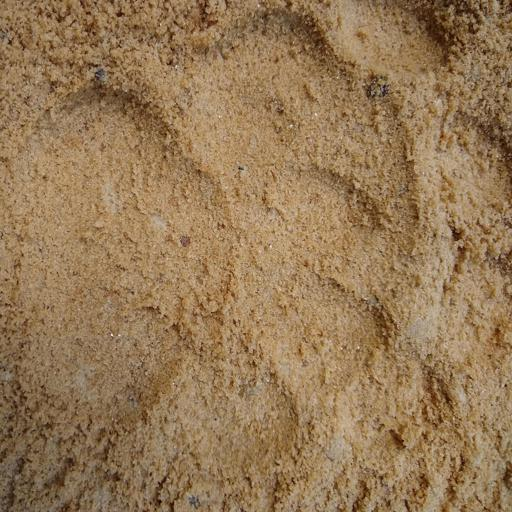
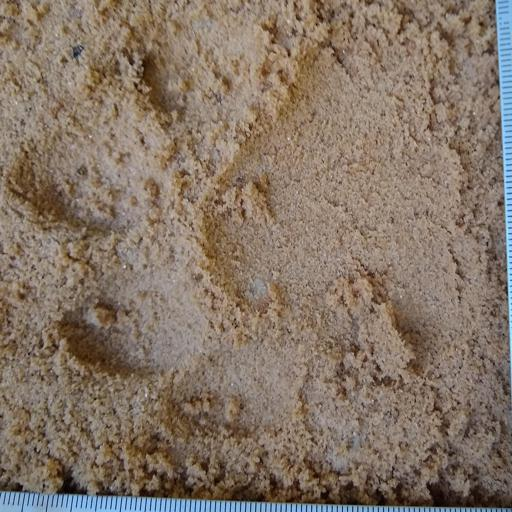
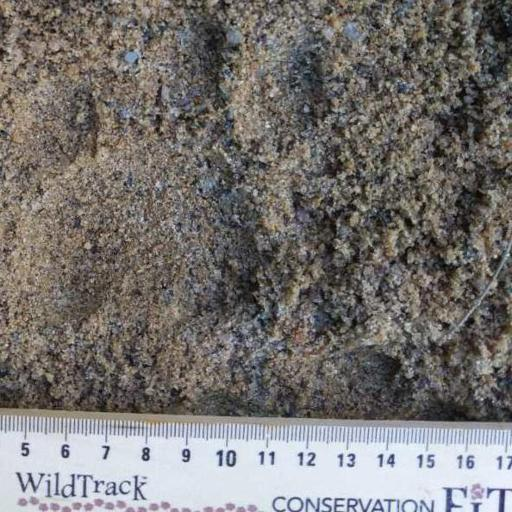
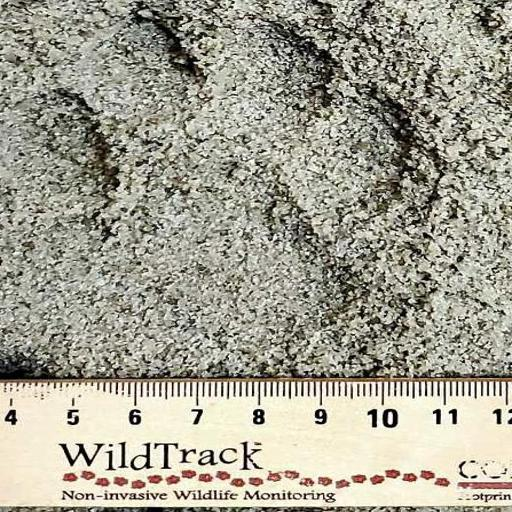
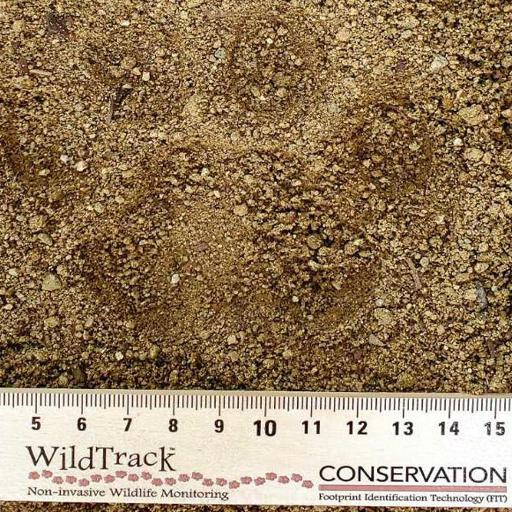

In [19]:
#sample first 10 images for review
misclassified_low_df = test_df[test_df['misclassified_low'] == 1].head(10)

low_html = misclassified_low_df.to_html(escape=False)
display(HTML(low_html))

Visually many of these images do seem low quality however one thought is perhaps they could be classified because of other common things that appea in the image (e.g. same substrate, same ruler, etc)?
